# 한-영 번역기 만들기 (v4.1: 토크나이저 및 하이퍼파라미터 개선)
---
## v4.0 대비 변경 사항
1.  **영어 토크나이저 변경**: `string.split()` -> `spaCy`
    - 단순 공백 기준이 아닌, 언어학적 특성을 고려한 토크나이저를 사용하여 구두점, 축약형 등을 더 잘 처리합니다.
2.  **하이퍼파라미터 조정**:
    - `HID_DIM`: 256 -> 512 (모델 용량 증대)
    - `N_LAYERS`: 1 -> 2 (모델 깊이 추가)
    - `DROPOUT`: 0.6 -> 0.5 (드롭아웃 비율 감소)

## Step 1. 라이브러리 설치 및 임포트

In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_sm

# !apt-get install -y fonts-nanum

# !pip install Korpora
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# !ls
# %cd Mecab-ko-for-Google-Colab/
# !bash install_mecab-ko_on_colab_light_220429.sh

# %cd ..

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import os
import re
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import random
import time
from tqdm import tqdm
import spacy

import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


## Step 2. 데이터 준비 및 전처리

In [3]:
data_dir = 'data'

train_kor_path = os.path.join(data_dir, 'korean-english-park.train.ko')
train_eng_path = os.path.join(data_dir, 'korean-english-park.train.en')
dev_kor_path = os.path.join(data_dir, 'korean-english-park.dev.ko')
dev_eng_path = os.path.join(data_dir, 'korean-english-park.dev.en')
test_kor_path = os.path.join(data_dir, 'korean-english-park.test.ko')
test_eng_path = os.path.join(data_dir, 'korean-english-park.test.en')

with open(train_kor_path, "r") as f: train_kor_raw = f.read().splitlines()
with open(train_eng_path, "r") as f: train_eng_raw = f.read().splitlines()
with open(dev_kor_path, "r") as f: dev_kor_raw = f.read().splitlines()
with open(dev_eng_path, "r") as f: dev_eng_raw = f.read().splitlines()
with open(test_kor_path, "r") as f: test_kor_raw = f.read().splitlines()
with open(test_eng_path, "r") as f: test_eng_raw = f.read().splitlines()

### 전처리 및 토큰화 함수 정의 (spaCy 적용)

In [4]:
mecab = Mecab()
spacy_eng = spacy.load('en_core_web_sm')

def preprocess_corpus(kor_sentence, eng_sentence):
    # 영어 문장 전처리 시, 문자열에 직접 토큰을 추가하지 않습니다.
    kor_sentence = kor_sentence.lower().strip()
    kor_sentence = re.sub(r"([^가-힣?.!,]+)", " ", kor_sentence)

    eng_sentence = eng_sentence.lower().strip()
    eng_sentence = re.sub(r"([?.!,])", r" \\1 ", eng_sentence)
    eng_sentence = re.sub(r'[^a-zA-Z?.!,]+', ' ', eng_sentence)
    eng_sentence = re.sub(r'\\s+', ' ', eng_sentence)

    return kor_sentence, eng_sentence.strip()

def tokenize_corpus(kor_raw, eng_raw, max_len=40):
    kor_corpus, eng_corpus = [], []
    cleaned_corpus = list(set(zip(kor_raw, eng_raw)))
    for kor, eng in cleaned_corpus:
        kor_prep, eng_prep = preprocess_corpus(kor, eng)

        kor_tokens = mecab.morphs(kor_prep)
        eng_tokens_raw = [token.text for token in spacy_eng.tokenizer(eng_prep)]

        # 토큰화가 끝난 리스트에 특수 토큰을 추가합니다.
        eng_tokens = ['<start>'] + eng_tokens_raw + ['<end>']

        if len(kor_tokens) <= max_len and len(eng_tokens) <= max_len:
            kor_corpus.append(kor_tokens)
            eng_corpus.append(eng_tokens)

    return kor_corpus, eng_corpus

# 훈련 데이터 토크나이즈
train_kor_corpus, train_eng_corpus = tokenize_corpus(train_kor_raw, train_eng_raw)

### 단어 사전 구축

In [5]:
def build_vocab(corpus, max_vocab_size=10000):
    counter = Counter()
    for sentence in corpus:
        counter.update(sentence)

    vocab = counter.most_common(max_vocab_size - 4)
    word_to_idx = {word: i+4 for i, (word, _) in enumerate(vocab)}

    word_to_idx['<pad>'] = 0
    word_to_idx['<unk>'] = 1
    word_to_idx['<start>'] = 2
    word_to_idx['<end>'] = 3

    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    return word_to_idx, idx_to_word

kor_word_to_idx, kor_idx_to_word = build_vocab(train_kor_corpus)
eng_word_to_idx, eng_idx_to_word = build_vocab(train_eng_corpus)

### 데이터셋을 숫자 시퀀스로 변환

In [6]:
def text_to_sequence(corpus, word_to_idx):
    sequences = []
    for sentence in corpus:
        sequence = [word_to_idx.get(word, word_to_idx['<unk>']) for word in sentence]
        sequences.append(sequence)
    return sequences

# 개발(validation) 데이터 전처리
dev_kor_corpus, dev_eng_corpus = [], []
for kor, eng in zip(dev_kor_raw, dev_eng_raw):
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    kor_tokens = mecab.morphs(kor_prep)
    eng_tokens_raw = [token.text for token in spacy_eng.tokenizer(eng_prep)]
    eng_tokens = ['<start>'] + eng_tokens_raw + ['<end>']
    dev_kor_corpus.append(kor_tokens)
    dev_eng_corpus.append(eng_tokens)

# 테스트 데이터 전처리
test_kor_corpus, test_eng_corpus = [], []
for kor, eng in zip(test_kor_raw, test_eng_raw):
    kor_prep, eng_prep = preprocess_corpus(kor, eng)
    kor_tokens = mecab.morphs(kor_prep)
    eng_tokens_raw = [token.text for token in spacy_eng.tokenizer(eng_prep)]
    eng_tokens = ['<start>'] + eng_tokens_raw + ['<end>']
    test_kor_corpus.append(kor_tokens)
    test_eng_corpus.append(eng_tokens)

# 훈련, 개발, 테스트 데이터 모두 단어 인덱스 시퀀스로 변환
train_kor_sequences = text_to_sequence(train_kor_corpus, kor_word_to_idx)
train_eng_sequences = text_to_sequence(train_eng_corpus, eng_word_to_idx)
dev_kor_sequences = text_to_sequence(dev_kor_corpus, kor_word_to_idx)
dev_eng_sequences = text_to_sequence(dev_eng_corpus, eng_word_to_idx)
test_kor_sequences = text_to_sequence(test_kor_corpus, kor_word_to_idx)
test_eng_sequences = text_to_sequence(test_eng_corpus, eng_word_to_idx)

## Step 3. 모델 설계 및 데이터셋 준비

In [7]:
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.src_sequences[idx]), torch.tensor(self.trg_sequences[idx])

def collate_fn(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=kor_word_to_idx['<pad>'])
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=eng_word_to_idx['<pad>'])
    return src_padded, trg_padded

BATCH_SIZE = 64

train_dataset = TranslationDataset(train_kor_sequences, train_eng_sequences)
valid_dataset = TranslationDataset(dev_kor_sequences, dev_eng_sequences)
test_dataset = TranslationDataset(test_kor_sequences, test_eng_sequences)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

### Attention 기반 Seq2Seq 모델 설계

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=kor_word_to_idx['<pad>'])
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        hidden = hidden.view(self.n_layers, 2, -1, self.hidden_dim)
        hidden = torch.cat((hidden[:, 0, :, :], hidden[:, 1, :, :]), dim=2)
        hidden = torch.tanh(self.fc(hidden))
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, values):
        query = query.unsqueeze(1)
        score = self.V(torch.tanh(self.W1(query) + self.W2(values)))
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * values
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector, attention_weights.squeeze(-1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=eng_word_to_idx['<pad>'])
        self.rnn = nn.GRU((hidden_dim * 2) + emb_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))
        context_vector, attention_weights = self.attention(hidden[-1], encoder_outputs)
        context_vector = context_vector.unsqueeze(1)
        rnn_input = torch.cat((embedded, context_vector), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, attention_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        src_len = src.shape[1]
        trg_vocab_size = self.decoder.output_dim
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src_len).to(self.device)
        encoder_outputs, hidden = self.encoder(src)
        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t, :] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs, attentions

## Step 4. 모델 학습 및 검증

### 하이퍼파라미터 설정 (v4.1)

In [9]:
VOCAB_SIZE = 10000
INPUT_DIM = VOCAB_SIZE
OUTPUT_DIM = VOCAB_SIZE
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512  # 256 -> 512
N_LAYERS = 2   # 1 -> 2
ENC_DROPOUT = 0.5 # 0.6 -> 0.5
DEC_DROPOUT = 0.5 # 0.6 -> 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = BahdanauAttention(HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attn)
model = Seq2Seq(enc, dec, device).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=eng_word_to_idx['<pad>'], label_smoothing=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

### 학습 및 평가 함수 정의

In [10]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", leave=False)

    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.long().to(device), trg.long().to(device)
        optimizer.zero_grad()
        output, _ = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src, trg = batch
            src, trg = src.long().to(device), trg.long().to(device)
            output, _ = model(src, trg, 0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

### 학습 루프 실행

In [11]:
def display_attention(sentence_tokens, translation_tokens, attention):
    fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
    fontprop = fm.FontProperties(fname=fontpath, size=12)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    attention = attention.cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='viridis')

    ax.set_xticks(range(len(sentence_tokens)))
    ax.set_xticklabels(sentence_tokens, rotation=90, fontproperties=fontprop)
    ax.set_yticks(range(len(translation_tokens)))
    ax.set_yticklabels(translation_tokens)

    ax.tick_params(labelsize=12)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device, max_len=50):
    model.eval()
    tokens = mecab.morphs(sentence)
    src_indexes = [kor_word_to_idx.get(t, kor_word_to_idx['<unk>']) for t in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [eng_word_to_idx['<start>']]
    attentions = torch.zeros(max_len, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention.squeeze(0)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        if pred_token == eng_word_to_idx['<end>']:
            break

    trg_tokens = [eng_idx_to_word.get(i, '<unk>') for i in trg_indexes]

    translation_tokens = []
    for token in trg_tokens[1:]:
        if token == '<end>':
            break
        translation_tokens.append(token)

    print(f'Original: {sentence}')
    print(f"Translated: {' '.join(translation_tokens)}")
    display_attention(tokens, translation_tokens, attentions[:len(translation_tokens)])

  * Best Val. Loss updated: 7.016
Epoch: 01 | Time: 5.0m 46s
	Current LR: 0.001000
	Train Loss: 7.098 | Train PPL: 1210.047
	 Val. Loss: 7.016 |  Val. PPL: 1114.003

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


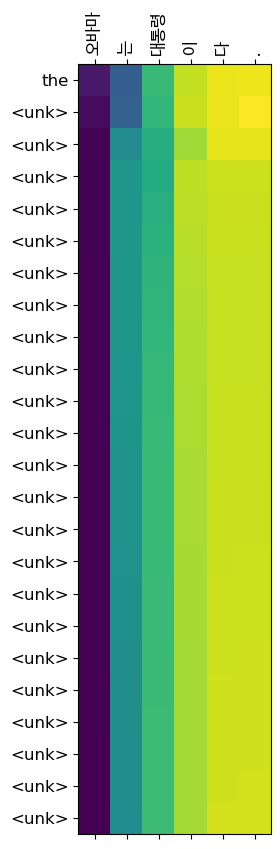

  * Best Val. Loss updated: 6.858
Epoch: 02 | Time: 5.0m 50s
	Current LR: 0.001000
	Train Loss: 6.895 | Train PPL: 987.061
	 Val. Loss: 6.858 |  Val. PPL: 951.801

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: the korea s the to the the the the the the the the


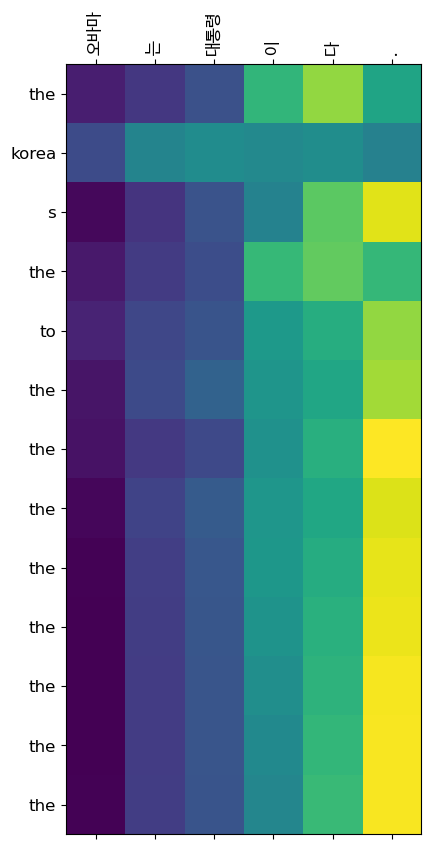

  * Best Val. Loss updated: 6.729
Epoch: 03 | Time: 5.0m 50s
	Current LR: 0.001000
	Train Loss: 6.570 | Train PPL: 713.096
	 Val. Loss: 6.729 |  Val. PPL: 836.698

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s obama and obama s obama and the obama s the


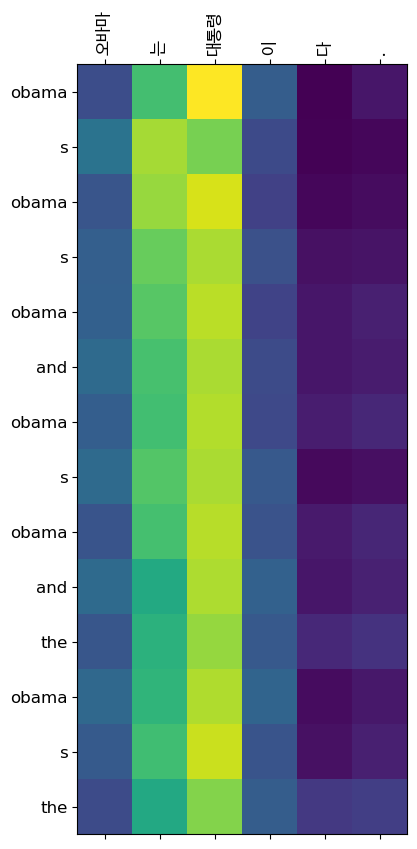

  * Best Val. Loss updated: 6.690
Epoch: 04 | Time: 5.0m 51s
	Current LR: 0.001000
	Train Loss: 6.379 | Train PPL: 589.275
	 Val. Loss: 6.690 |  Val. PPL: 804.250

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s to the the the the


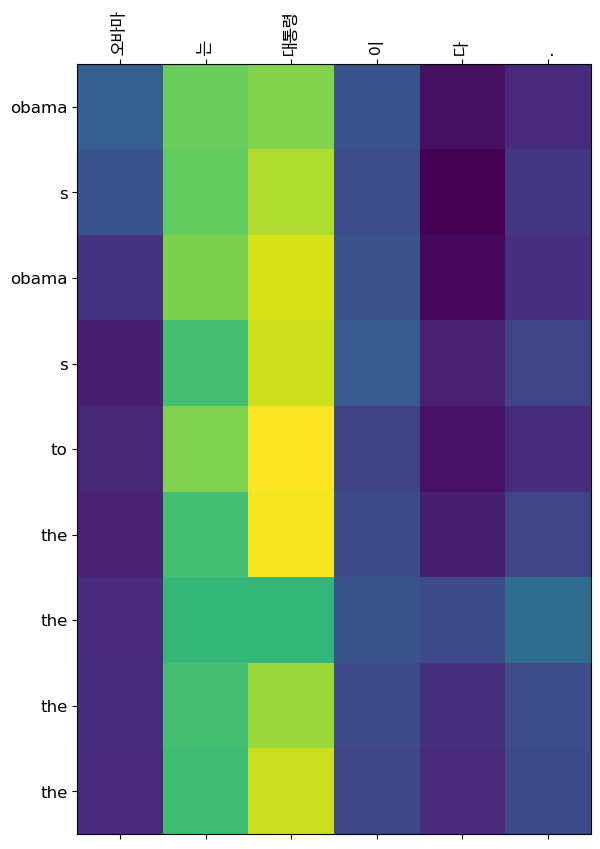

  * Best Val. Loss updated: 6.652
Epoch: 05 | Time: 5.0m 52s
	Current LR: 0.001000
	Train Loss: 6.254 | Train PPL: 520.078
	 Val. Loss: 6.652 |  Val. PPL: 774.698

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s a president obama is to a president of obama s president


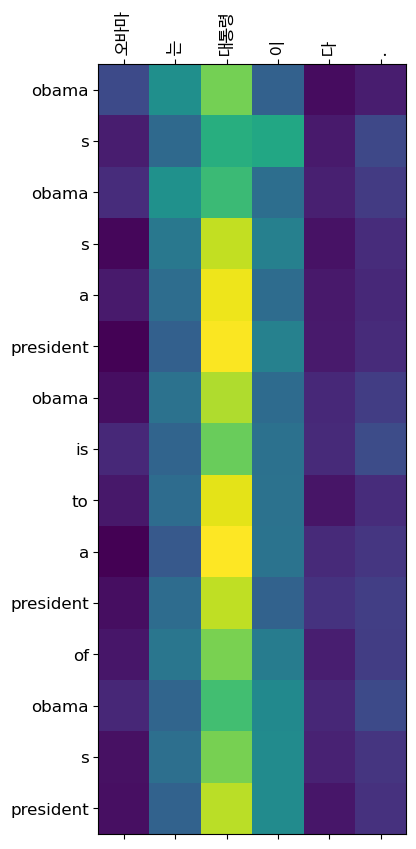

  * Best Val. Loss updated: 6.648
Epoch: 06 | Time: 5.0m 52s
	Current LR: 0.001000
	Train Loss: 6.159 | Train PPL: 472.733
	 Val. Loss: 6.648 |  Val. PPL: 771.363

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s first time of the obama s president obama s the


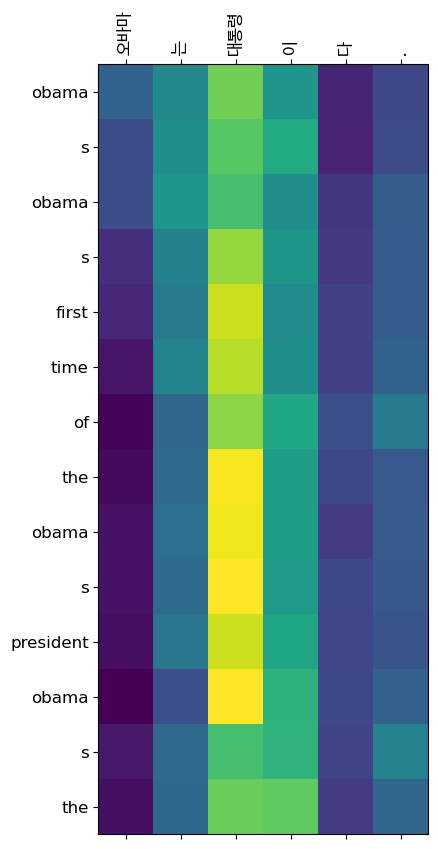

  * Early Stopping Counter: 1/5
Epoch: 07 | Time: 5.0m 51s
	Current LR: 0.001000
	Train Loss: 6.075 | Train PPL: 434.816
	 Val. Loss: 6.651 |  Val. PPL: 773.219

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s first time in the president elect barack obama s president elect barack obama


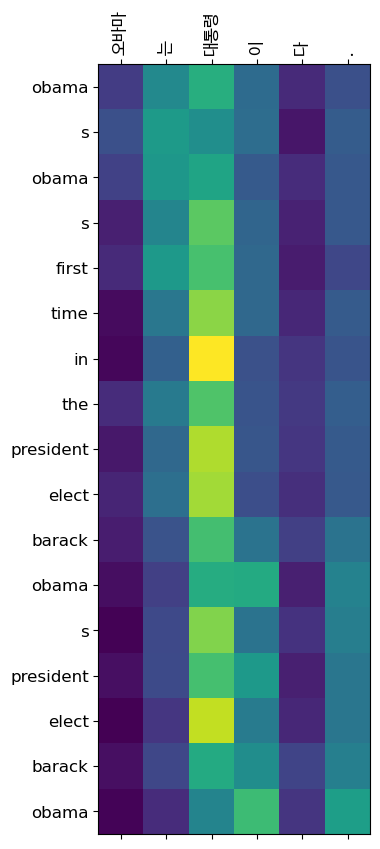

  * Best Val. Loss updated: 6.630
Epoch: 08 | Time: 5.0m 52s
	Current LR: 0.001000
	Train Loss: 6.004 | Train PPL: 405.145
	 Val. Loss: 6.630 |  Val. PPL: 757.725

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s president barack obama s president barack obama s president barack obama


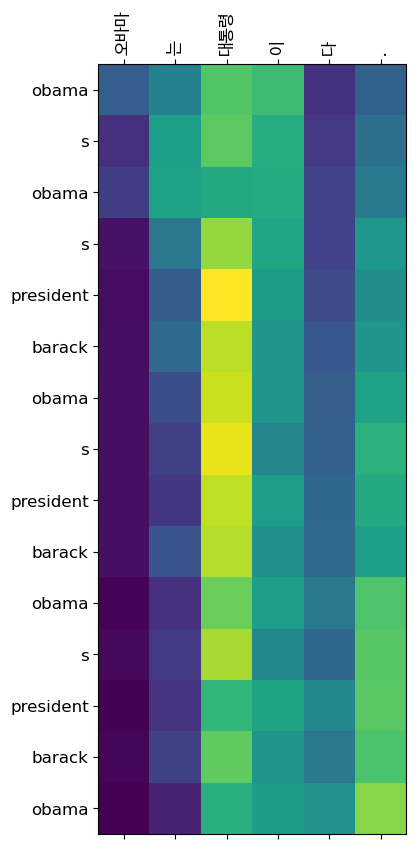

  * Best Val. Loss updated: 6.625
Epoch: 09 | Time: 5.0m 51s
	Current LR: 0.001000
	Train Loss: 5.950 | Train PPL: 383.882
	 Val. Loss: 6.625 |  Val. PPL: 753.658

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s first time of the president elect barack obama s inauguration


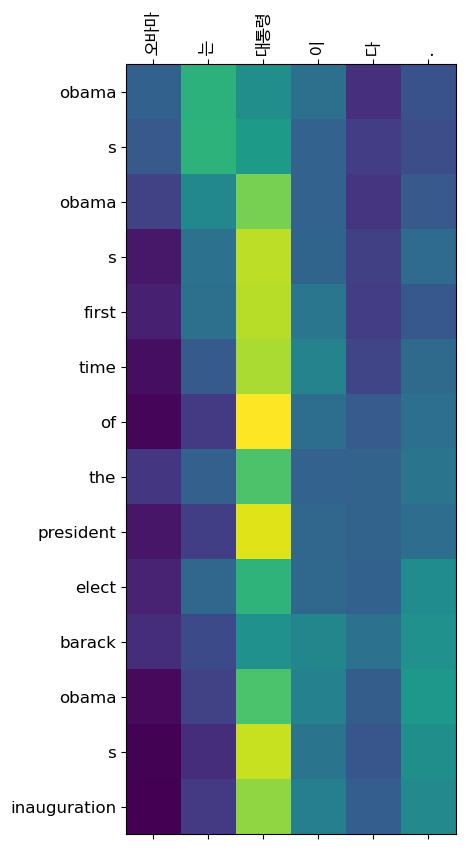

  * Early Stopping Counter: 1/5
Epoch: 10 | Time: 5.0m 51s
	Current LR: 0.001000
	Train Loss: 5.895 | Train PPL: 363.119
	 Val. Loss: 6.642 |  Val. PPL: 766.434

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is obama s first time to the president barack obama s obama


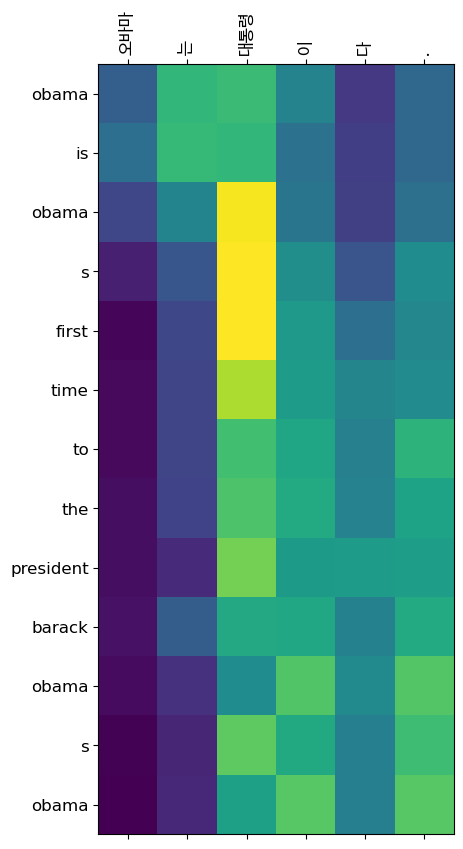

  * Early Stopping Counter: 2/5
Epoch: 11 | Time: 5.0m 52s
	Current LR: 0.001000
	Train Loss: 5.843 | Train PPL: 344.884
	 Val. Loss: 6.626 |  Val. PPL: 754.718

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama is the first time obama s president of the oval president


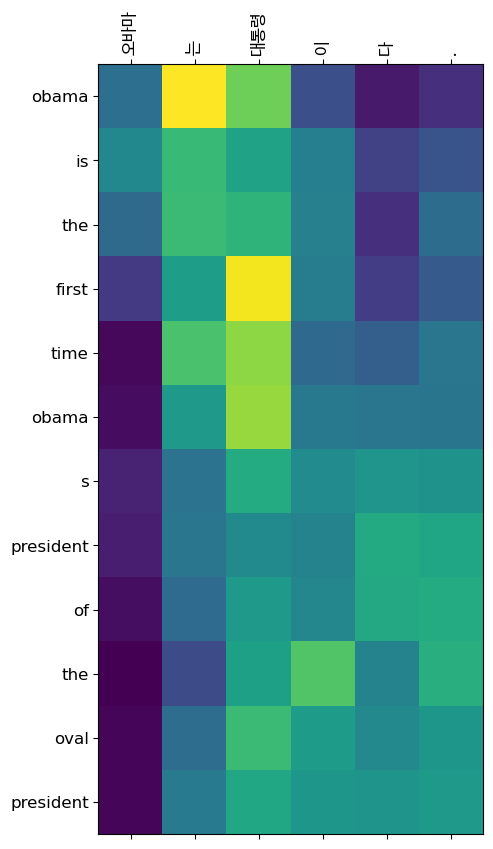

  * Early Stopping Counter: 3/5
Epoch: 12 | Time: 5.0m 52s
	Current LR: 0.000500
	Train Loss: 5.799 | Train PPL: 330.007
	 Val. Loss: 6.627 |  Val. PPL: 755.022

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s first lady of the president s president elect barack obama s


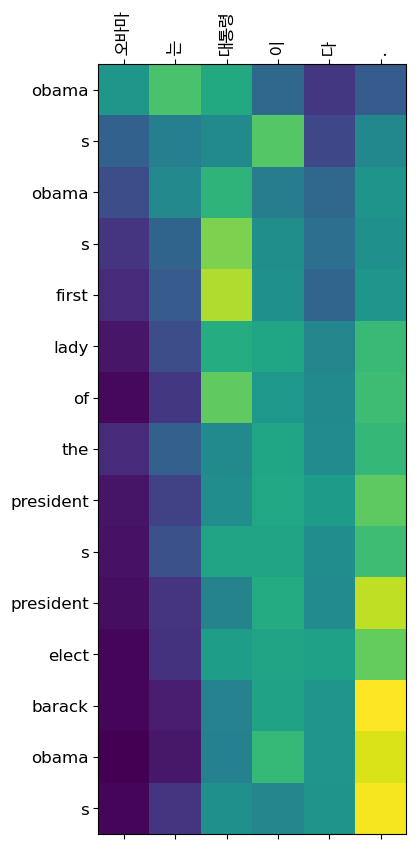

  * Best Val. Loss updated: 6.587
Epoch: 13 | Time: 5.0m 52s
	Current LR: 0.000500
	Train Loss: 5.678 | Train PPL: 292.499
	 Val. Loss: 6.587 |  Val. PPL: 725.573

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s obama s first time obama s president obama has been a to president


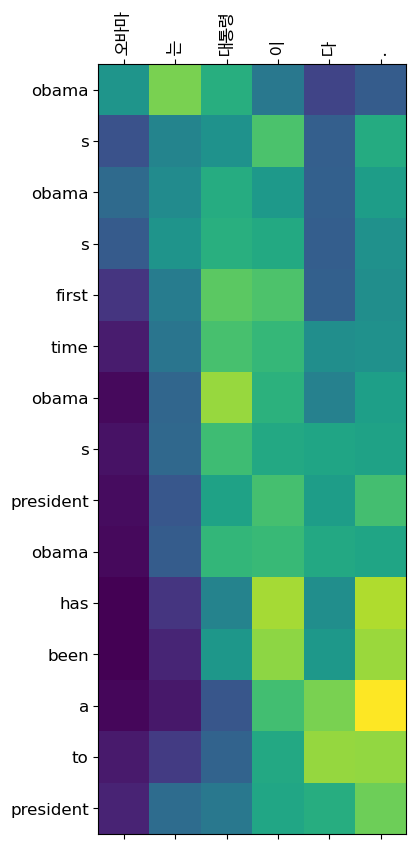

  * Best Val. Loss updated: 6.577
Epoch: 14 | Time: 5.0m 51s
	Current LR: 0.000500
	Train Loss: 5.629 | Train PPL: 278.465
	 Val. Loss: 6.577 |  Val. PPL: 718.147

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s president elect barack obama s a president of the president elect is a


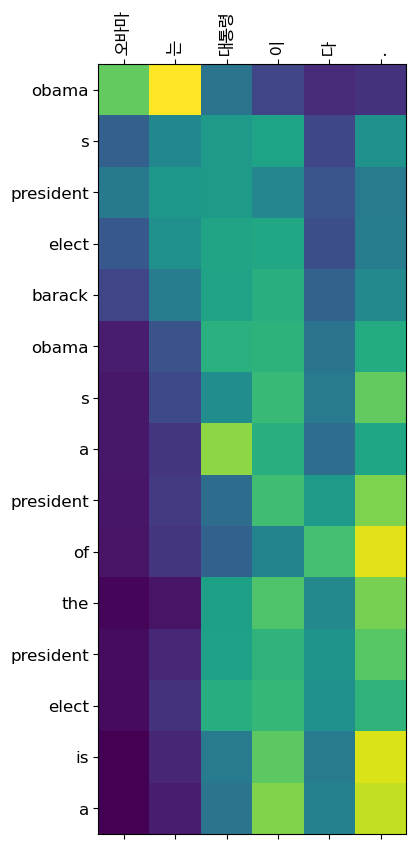

  * Best Val. Loss updated: 6.576
Epoch: 15 | Time: 5.0m 51s
	Current LR: 0.000500
	Train Loss: 5.588 | Train PPL: 267.111
	 Val. Loss: 6.576 |  Val. PPL: 717.603

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s president is the first time of the president s president


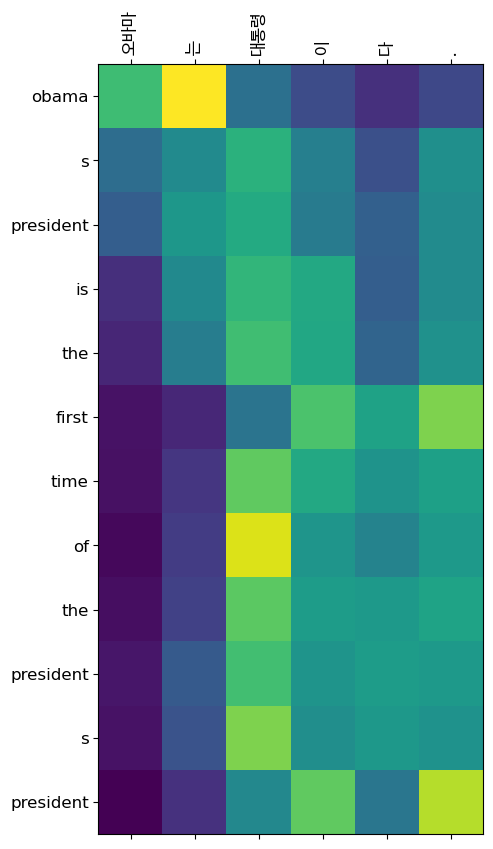

  * Early Stopping Counter: 1/5
Epoch: 16 | Time: 5.0m 51s
	Current LR: 0.000500
	Train Loss: 5.555 | Train PPL: 258.614
	 Val. Loss: 6.584 |  Val. PPL: 723.445

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s the president of the president elect has been a to president elect barack obama s office


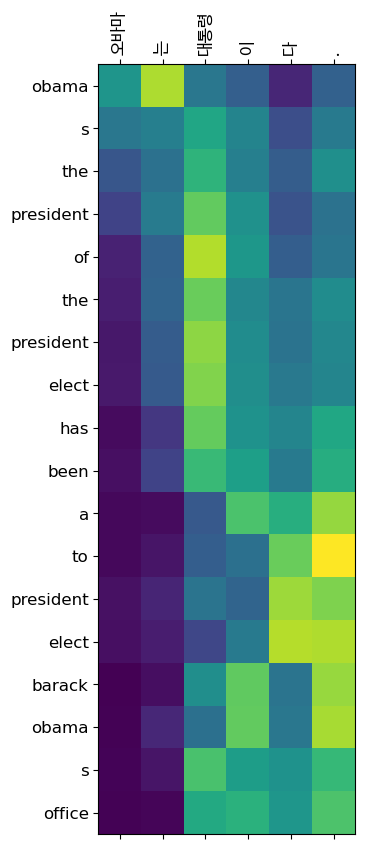

  * Early Stopping Counter: 2/5
Epoch: 17 | Time: 5.0m 52s
	Current LR: 0.000500
	Train Loss: 5.520 | Train PPL: 249.518
	 Val. Loss: 6.597 |  Val. PPL: 732.618

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s president is the president of the illinois s president


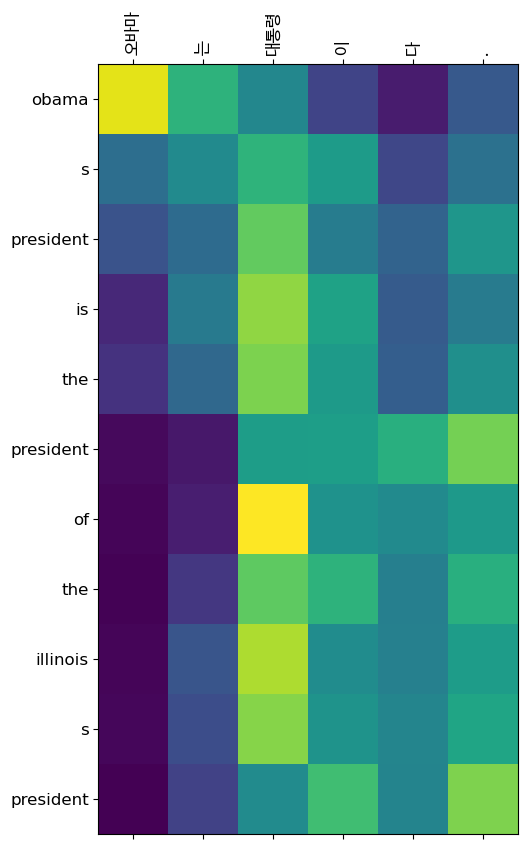

  * Early Stopping Counter: 3/5
Epoch: 18 | Time: 5.0m 52s
	Current LR: 0.000250
	Train Loss: 5.494 | Train PPL: 243.237
	 Val. Loss: 6.605 |  Val. PPL: 738.766

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s president is expected to be a the president of the oval office


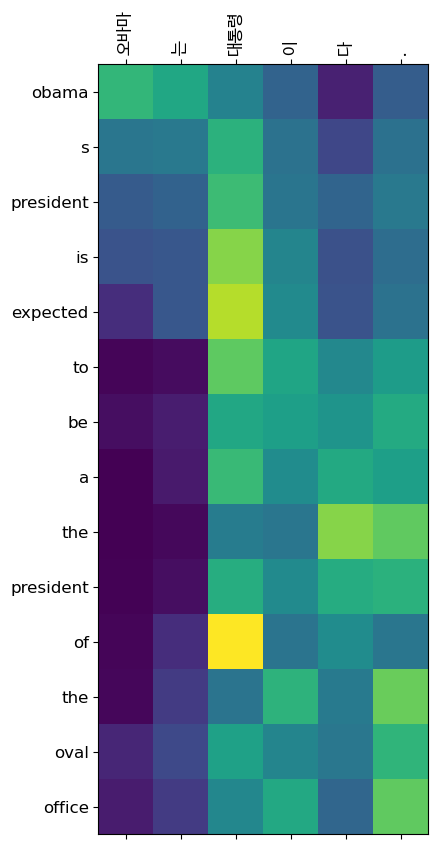

  * Early Stopping Counter: 4/5
Epoch: 19 | Time: 5.0m 52s
	Current LR: 0.000250
	Train Loss: 5.417 | Train PPL: 225.295
	 Val. Loss: 6.587 |  Val. PPL: 725.405

--- Checking Attention Map ---
Original: 오바마는 대통령이다.
Translated: obama s the first time to president elect barack obama s president


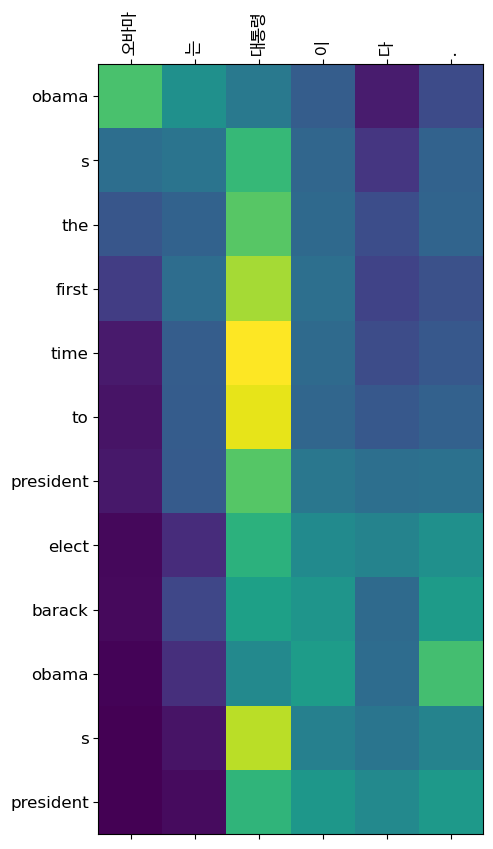

  * Early Stopping Counter: 5/5

[Early Stopping] Validation loss did not improve for 5 epochs. Stopping training...


In [12]:
N_EPOCHS = 100
CLIP = 1
PATIENCE = 5

best_valid_loss = float('inf')
patience_counter = 0
attention_check_sentence = "오바마는 대통령이다."

for epoch in range(N_EPOCHS):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'translator-ko-en-v4.1.pt')
        patience_counter = 0
        print(f"  * Best Val. Loss updated: {best_valid_loss:.3f}")
    else:
        patience_counter += 1
        print(f"  * Early Stopping Counter: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print(f"\n[Early Stopping] Validation loss did not improve for {PATIENCE} epochs. Stopping training...")
        break

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.0f}s')
    print(f'\tCurrent LR: {current_lr:.6f}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

    print("\n--- Checking Attention Map ---")
    translate_and_show_attention(attention_check_sentence, model, kor_word_to_idx, eng_idx_to_word, device)
    model.train()

## Step 5. 최종 테스트 및 번역 시각화

In [13]:
model.load_state_dict(torch.load('translator-ko-en-v4.1.pt'))
test_loss = evaluate(model, test_loader, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |')

| Test Loss: 6.634 | Test PPL: 760.573 |


Original: 오바마는 대통령이다.
Translated: obama s president is the first time of the president s president


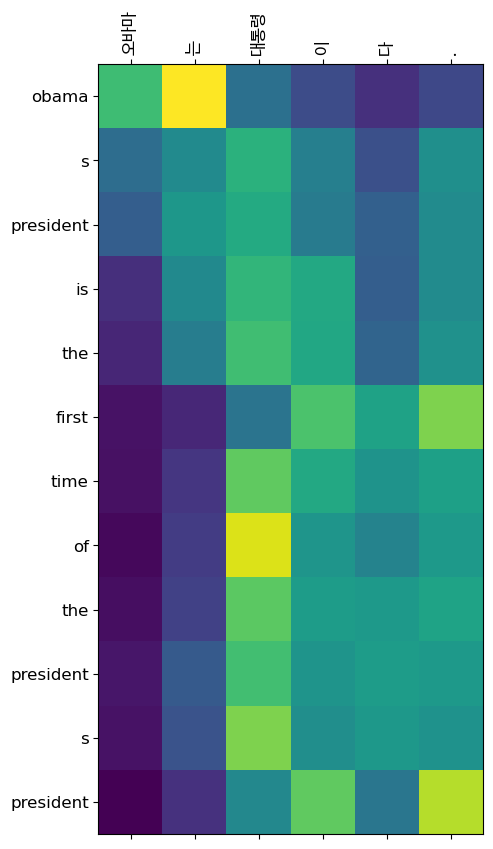


Original: 시민들은 도시 속에 산다.
Translated: the <unk> <unk> the <unk> of the <unk> <unk> the <unk> of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


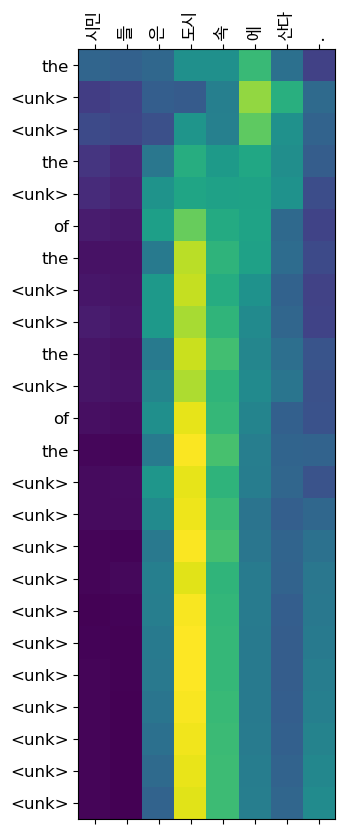


Original: 커피는 필요 없다.
Translated: the is not <unk> to <unk> the <unk> of the <unk>


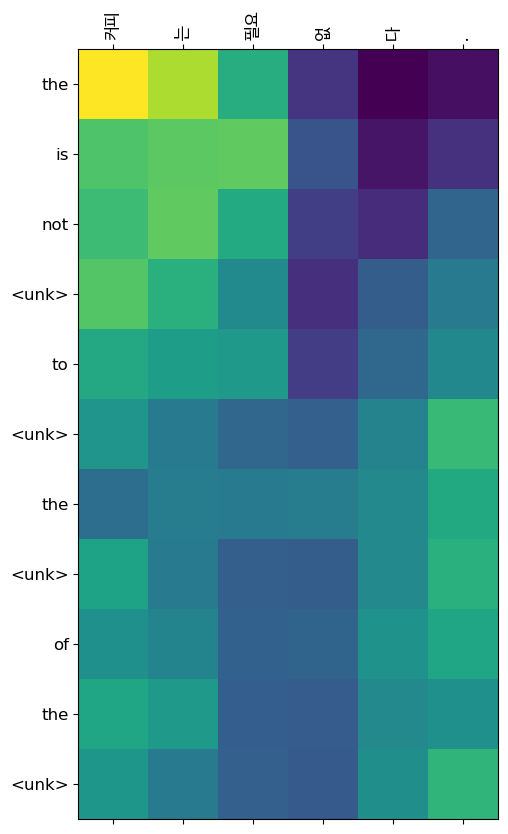


Original: 일곱 명의 사망자가 발생했다.
Translated: the of the people died in the of the and killed in the


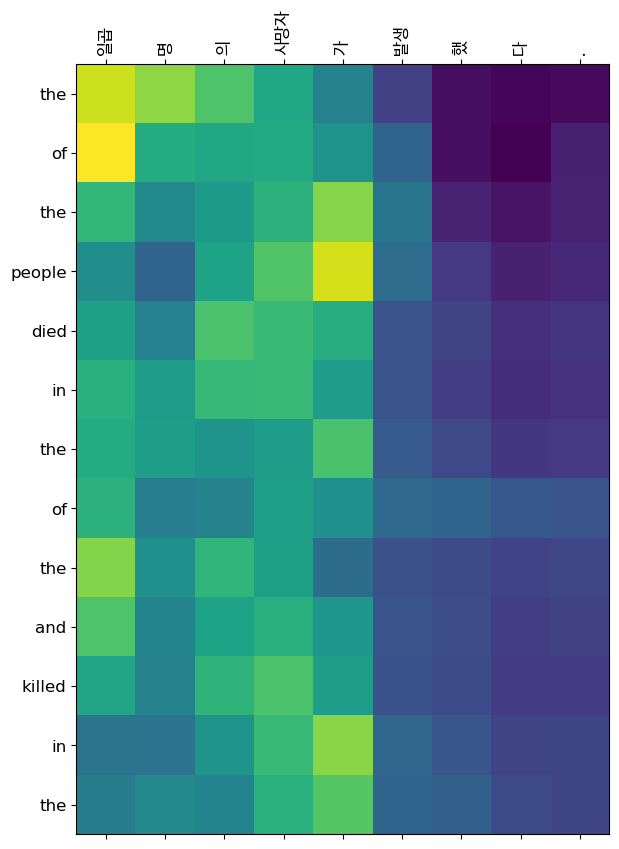

In [14]:
example_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in example_sentences:
    translate_and_show_attention(sentence, model, kor_word_to_idx, eng_idx_to_word, device)
    print()